In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as skds
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale
import optimization.optimization as opt
import optimization.datasets as ds


### simulate datasets for linear least squares

In [3]:
Xs_noise, ys_noise, coefs_noise = ds.generate_datasets(
    "noise", linear=True, noise=[0, 10, 100]
)

Xs_n_samples, ys_n_samples, coefs_n_samples = ds.generate_datasets(
    "n_samples", linear=True, n_samples=[500, 1000, 10000]
)

Xs_n_features, ys_n_features, coefs_n_features = ds.generate_datasets(
    "n_features", linear=True, n_features=[3, 5, 200]
)


>>> noise


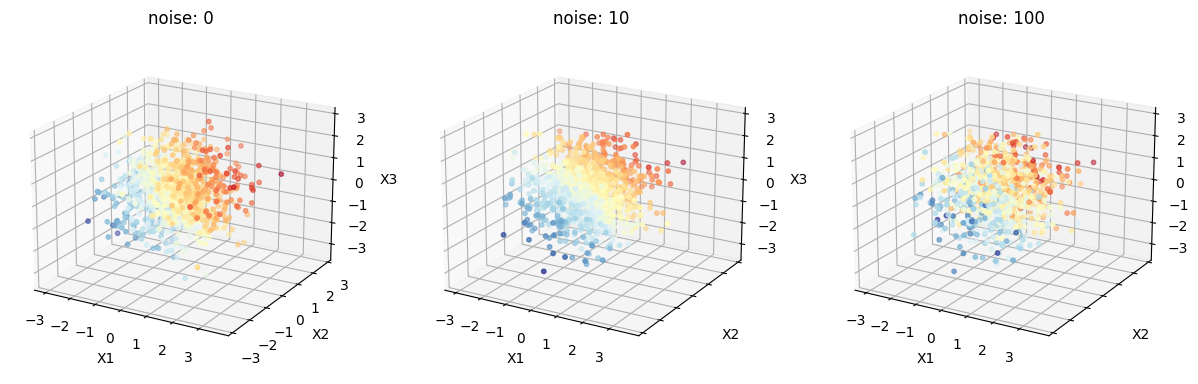

>>> n_samples


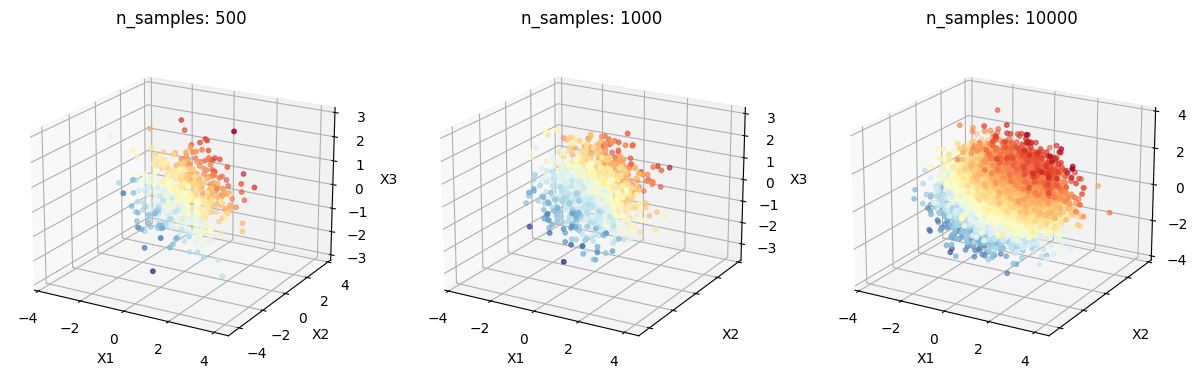

>>> n_features


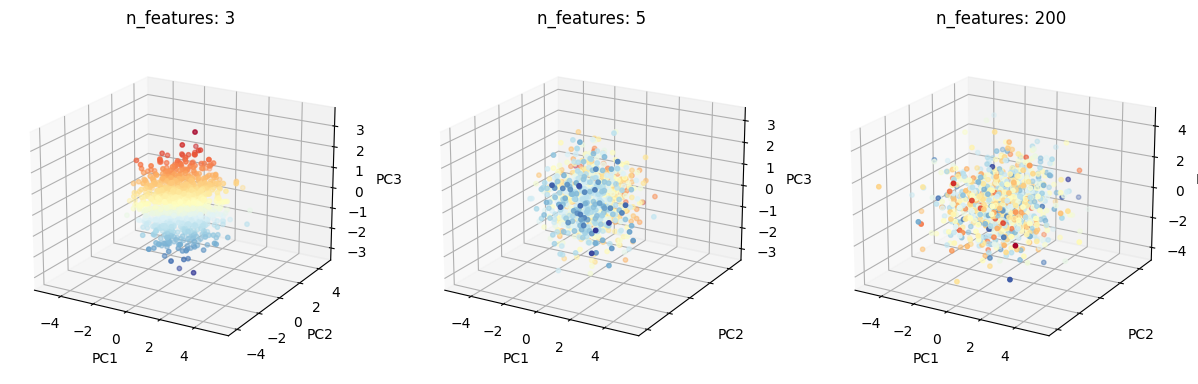

In [4]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()

print(">>> n_features")
ds.plot_3d_projection("n_features", Xs_n_features, ys_n_features)
plt.show()


### simulate datasets for non-linear least squares

In [5]:
Xs_noise, ys_noise, _ = ds.generate_datasets("noise", linear=False, noise=[0, 50, 100])
Xs_n_samples, ys_n_samples, _ = ds.generate_datasets(
    "n_samples", linear=False, n_samples=[500, 1000, 10000]
)


>>> noise


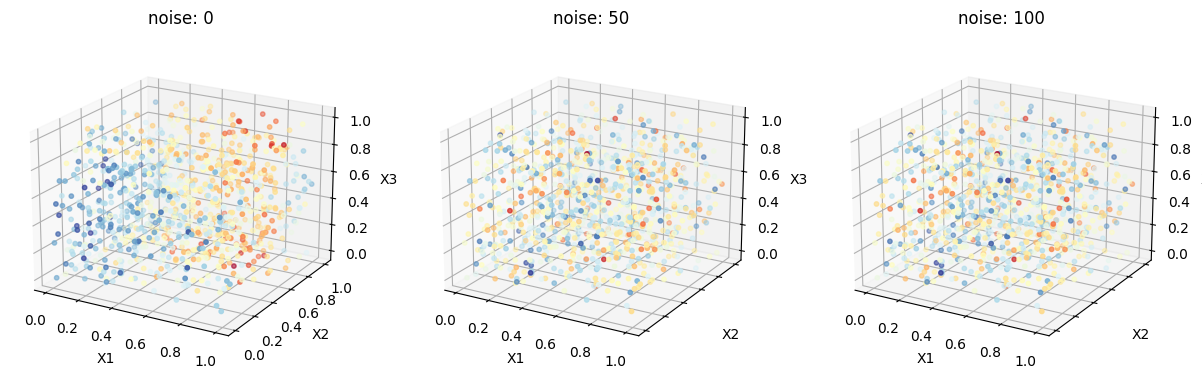

>>> n_samples


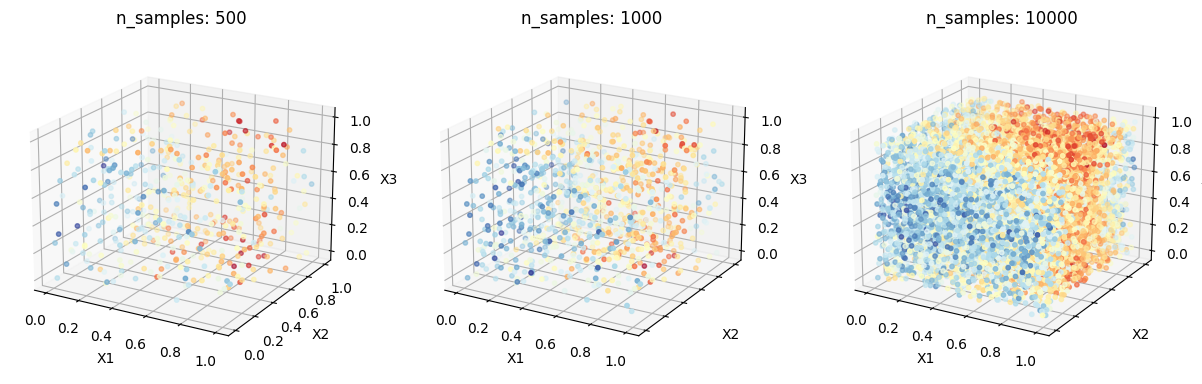

In [6]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()


### dataset examples

In [7]:
def _test_opt_datasets(X, y, method=None):
    """Test optimization methods and record their MSE, elapsed time, and loss."""

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    if method == "lstsq":
        coef_ = opt.normal_eq_lr(X_train, y_train)
        mse = ((y_test - X_test @ coef_) ** 2).mean()
        rmse = torch.sqrt(mse).item()
        print(f">>> {method}\nRMSE = {rmse:.3f}\n")
    else:
        coef_, loss, elapsed = opt.train_model(
            X_train, y_train, method=method, n_epochs=250
        )
        mse = ((y_test - X_test @ coef_) ** 2).mean()
        rmse = torch.sqrt(mse).item()
        print(f">>> {method}\nRMSE = {rmse:.3f} (elapsed time = {elapsed:.3f} s)\n")
        return np.sqrt(loss)  # root mean square loss


In [8]:
db = skds.load_diabetes(scaled=True)
db_X, db_y = db.data, db.target
print("(n_samples, n_features) =", db_X.shape)


(n_samples, n_features) = (442, 10)


Text(0.5, 0, 'Ys')

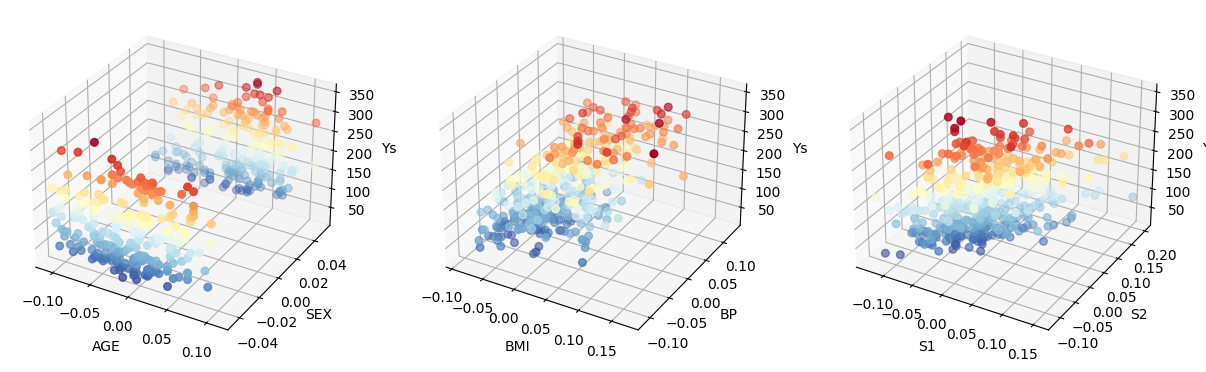

In [9]:
# marginal plots
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))

cmap = "RdYlBu_r"
axs[0].scatter(db_X[:, 0], db_X[:, 1], db_y, c=db_y, s=30, cmap=cmap)
axs[0].set_xlabel("AGE")
axs[0].set_ylabel("SEX")
axs[0].set_zlabel("Ys")

axs[1].scatter(db_X[:, 2], db_X[:, 3], db_y, c=db_y, s=30, cmap=cmap)
axs[1].set_xlabel("BMI")
axs[1].set_ylabel("BP")
axs[1].set_zlabel("Ys")

ax = axs[2].scatter(db_X[:, 4], db_X[:, 5], db_y, c=db_y, s=30, cmap=cmap)
axs[2].set_xlabel("S1")
axs[2].set_ylabel("S2")
axs[2].set_zlabel("Ys")


In [10]:
X = torch.tensor(db_X, dtype=torch.float32)
y = torch.tensor(db_y, dtype=torch.float32)

method = "lstsq"
coef_ = _test_opt_datasets(X, y, method=method)

method = "sgd"
sgd_loss = _test_opt_datasets(X, y, method=method)

method = "newton"
newton_loss = _test_opt_datasets(X, y, method=method)

method = "lbfgs"
lbfgs_loss = _test_opt_datasets(X, y, method=method)


>>> lstsq
RMSE = 165.253

>>> sgd
RMSE = 170.055 (elapsed time = 0.131 s)

>>> newton
RMSE = 174.754 (elapsed time = 1.106 s)

>>> lbfgs
RMSE = 173.445 (elapsed time = 2.442 s)



Text(0.5, 1.0, 'LBFGS')

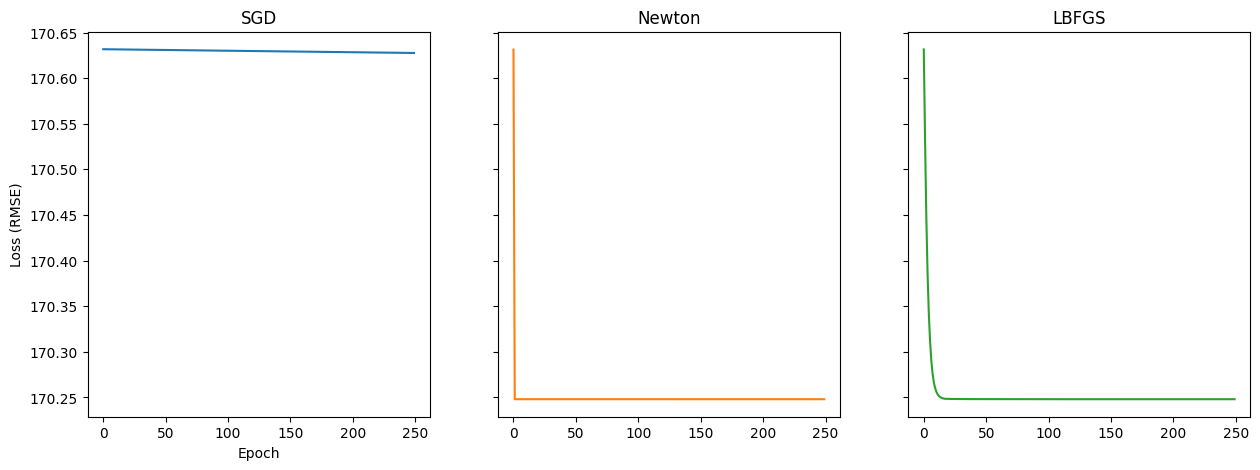

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].plot(sgd_loss, label="SGD", c="C0")
axs[0].set_title("SGD")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss (RMSE)")

axs[1].plot(newton_loss, label="Newton", c="C1")
axs[1].set_title("Newton")

axs[2].plot(lbfgs_loss, label="LBFGS", c="C2")
axs[2].set_title("LBFGS")


In [12]:
cal = skds.fetch_california_housing()
cal_X, cal_y = cal.data[:, :-2], cal.target
print("(n_samples, n_features) =", cal_X.shape)

(n_samples, n_features) = (20640, 6)


Text(0.5, 0, 'MedHouseVal')

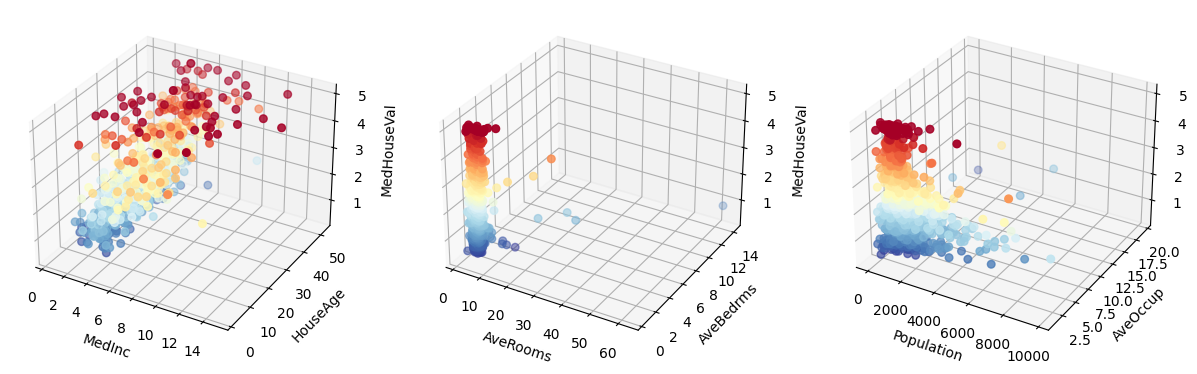

In [13]:
# marginal plots
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))

idx = np.random.choice(cal_X.shape[0], 1000, replace=False)
sX, sy = cal_X[idx, :], cal_y[idx]

axs[0].scatter(
    sX[:, 0],
    sX[:, 1],
    sy,
    c=sy,
    s=30,
    cmap=cmap,
)
axs[0].set_xlabel("MedInc")
axs[0].set_ylabel("HouseAge")
axs[0].set_zlabel("MedHouseVal")

axs[1].scatter(
    sX[:, 2],
    sX[:, 3],
    sy,
    c=sy,
    s=30,
    cmap=cmap,
)
axs[1].set_xlabel("AveRooms")
axs[1].set_ylabel("AveBedrms")
axs[1].set_zlabel("MedHouseVal")

axs[2].scatter(
    sX[:, 4],
    sX[:, 5],
    sy,
    c=sy,
    s=30,
    cmap=cmap,
)
axs[2].set_xlabel("Population")
axs[2].set_ylabel("AveOccup")
axs[2].set_zlabel("MedHouseVal")


In [14]:
# !!! ~40min to run: SKIP TO NEXT CELL to load precomputed results !!!

X = torch.tensor(robust_scale(cal_X), dtype=torch.float32)
y = torch.tensor(robust_scale(cal_y), dtype=torch.float32)

method = "lstsq"
coef_ = _test_opt_datasets(X, y, method=method)

method = "sgd"
sgd_loss = _test_opt_datasets(X, y, method=method)

method = "newton"
newton_loss = _test_opt_datasets(X, y, method=method)

method = "lbfgs"
lbfgs_loss = _test_opt_datasets(X, y, method=method)


>>> lstsq
RMSE = 0.544

>>> sgd
RMSE = 0.804 (elapsed time = 167.612 s)

>>> newton
RMSE = 0.777 (elapsed time = 1392.783 s)

>>> lbfgs
RMSE = 0.804 (elapsed time = 832.640 s)



Text(0.5, 1.0, 'LBFGS')

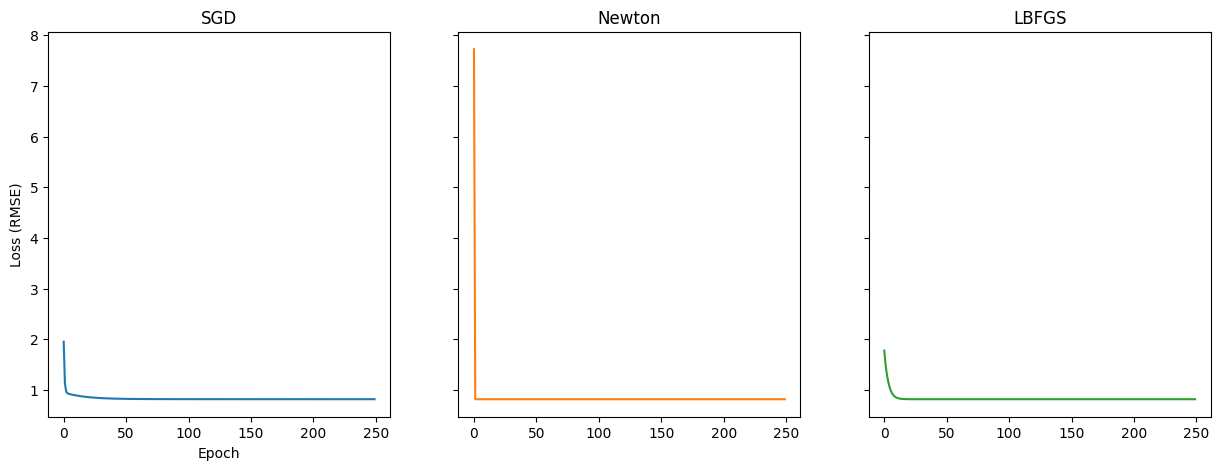

In [19]:
sgd_loss = np.load("../results/dataset2_rmse_sgd.npy")
newton_loss = np.load("../results/dataset2_rmse_newton.npy")
lbfgs_loss = np.load("../results/dataset2_rmse_lbfgs.npy")

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].plot(sgd_loss, label="SGD", c="C0")
axs[0].set_title("SGD")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss (RMSE)")

axs[1].plot(newton_loss, label="Newton", c="C1")
axs[1].set_title("Newton")

axs[2].plot(lbfgs_loss, label="LBFGS", c="C2")
axs[2].set_title("LBFGS")
